In [1]:
%pylab
%matplotlib inline
rc('text', usetex = True)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [3]:
#import pyfits as fits
from numpy import polyfit
#from astropy.utils.data import download_file
import pandas as pd
#import lmfit as lm

In [6]:
## Grab data
filename = '../r16_table4.out'
sne_start = 40
sne_end = 59
sne_lines = arange(sne_start,sne_end)
sne = pd.DataFrame(columns = ['Host', 'sne', 'm^B_0', 'err'], index = arange(sne_end - sne_start))
ceph_start = 70
ceph_end = 2346
cepheid_lines = arange(ceph_start,ceph_end)
cepheids = pd.DataFrame(columns = ['Field','RA','DEC','ID','Period','VminusI','m_H','sigma_tot','Z'], 
                        index = arange(ceph_end - ceph_start),
                       dtype = 'float')
f = open(filename, 'r')
for i, line in enumerate(f):
    if i in sne_lines:
        sne.loc[i-sne_start] = line.lower().split()
    if i in cepheid_lines:
        cepheids.loc[i-ceph_start] = line.lower().split()

f.close()
cepheids = cepheids.apply(lambda x: pd.to_numeric(x, errors='ignore') );
sne = sne.apply(lambda x: pd.to_numeric(x, errors='ignore') );

In [7]:
sne

,Host,sne,m^B_0,err
0,n3021,1995al,12.9630,0.117
1,n3370,1994ae,12.9120,0.116
2,n1309,2002fk,13.1920,0.117
3,n3982,1998aq,12.2310,0.115
4,n4639,1990n,12.4190,0.115
5,n5584,2007af,12.7010,0.116
6,n4038,2007sr,12.2330,0.115
7,n4536,1981b,11.6130,0.124
8,n1015,2009ig,13.4510,0.124
9,n1365,2012fr,11.9180,0.125


In [8]:
parallaxes = {'bgcru': (2.23, 0.30,-0.15), 
              'dtcyg':(2.19,0.33, -0.18), 
              'ffaql':(2.64,0.16, -0.03),
              'rtaur':(2.31, 0.19,-0.06),
              'sscma':(0.348, 0.038, -0.04),
              'sucas':(2.57,  0.33, -0.13 ),
              'syaur':(0.428, 0.054, -0.04),
              'tvul':(2.06,0.22,-0.09 ),
              'wsgr':(2.30, 0.19, -0.06),
              'xsgr':(3.17, 0.14, -0.02),
              'ysgr':(2.13, 0.29, -0.15),
              'betador':(3.26, 0.14, -0.02),
              'delceph':(3.71,0.12,-0.01),
              'etagem':(2.74,0.12,-0.02),
              'lcar':(2.03,0.16,-0.05)
             }
parallaxes = pd.DataFrame.from_dict(parallaxes, orient = 'index', )
parallaxes.reset_index(inplace=True)
parallaxes.columns = ['ID', 'parallax', 'p_err', 'LK']
cepheids = cepheids.merge(parallaxes, on = 'ID', how = 'left')

In [9]:
reddening_table = pd.read_csv('../table_2.scv', delim_whitespace = True,
                       names = ['Field', 'DV', 'DI', 'Dct', 'Dm_W', 'err_V', 'err_I', 'err_ct', 'err_m_W'])
reddening_table['Field'] = reddening_table['Field'].str.lower()
reddening_table

FileNotFoundError: File b'../table_2.scv' does not exist

In [10]:
class CosmoModel(object):
    def __init__(self, cepheids, sne):
        self.cepheids = cepheids
        self.sne = sne
        self.fields = set(self.cepheids.Field)
        self.mw_IDs = set(self.cepheids.loc[self.cepheids.Field == 'galaxy'].ID)
        self.Z_mean = mean(self.cepheids.Z)
        
        ### Set parameters
        self.params = lm.Parameters()
        ## Cepheid PL relation
        self.params.add('b_high', value = -3.0, vary = True)
        self.params.add('b_low', value = -3.0, vary = True)
        self.params.add('Z_w', value = 0.24, vary = True)
        self.params.add('M_ceph', value = -8, vary = True) #absolute magnitude for 1 day period cepheid
        self.params.add('R', value = 0.39, vary = False)
        ## Sne params
        self.params.add('M_0', value = -19, vary = True) #absolute magnitude for Sne
        
        ## \delta \mu parameters
        for field in self.fields:
            self.params.add('mu_'+field, value = 30, vary = True)
            self.params.add('R_'+field, value = 0, vary = False)
        self.params['mu_n4258'].vary = True
        #self.params['mu_n4258'].value = 0 
        self.params['mu_galaxy'].value = 0
        self.params['mu_galaxy'].vary = False
        ## H_0 determination
        #Sne intercept
        self.params.add('a_B', value = 0.71273, vary = True) 
        
        ## Distance Anchors
        #Maser distance n4258
        #self.params.add('d_4258', value = 5, vary = True) ##Mpc
        # MW parallaxes
        self.params.add('delta_zp', value = 0, vary = True) # zero point error ground/WFC3
        for ident in self.mw_IDs:
            self.params.add('pi_'+ident, value = 2.5, vary = True, min = 0)
            
            
        self.params.add('H0', vary = False, value = 66.93)
            
        self.sampler = lm.Minimizer(self.residual,
                                self.params,
                                scale_covar = False,
                                )
        
    def cepheid_mag(self, **params):
        self.cepheids.loc[:, 'm_theory'] = (params['M_ceph'] 
                  
                    +(
                        params['b_high']*(array(self.cepheids.Period) > 10)
                        + params['b_low']*(array(self.cepheids.Period)<=10)
                    ) * log10(self.cepheids.Period)
                                            
                  + params['Z_w'] * (self.cepheids.Z - 8.9)
                  
                  + self.params['R'] * self.cepheids.VminusI
                 )
        for field in (self.fields):
            self.cepheids.loc[self.cepheids.Field == field, 'm_theory'] += (params['mu_'+field] 
                                                                + params['R_'+field] * self.cepheids.VminusI)
            if field == 'lmc':
                self.cepheids.loc[self.cepheids.Field == field, 'm_theory'] += params['delta_zp']
            if field == 'galaxy':
                self.cepheids.loc[self.cepheids.Field == field, 'm_theory'] += params['delta_zp']
                for ident in self.mw_IDs:
                    self.cepheids.loc[self.cepheids.ID == ident, 'm_theory'] += (
                        5*log10((0.001/params['pi_'+ident]))
                        +25
                        -self.cepheids.loc[self.cepheids.ID == ident,'LK']
                    )
    
    def sne_mag(self, **params):
        self.sne.loc[:,'m_theory'] = params['M_0']
        for field in (self.fields):
            self.sne.loc[self.sne.Host == field, 'm_theory'] += params['mu_'+field]
    
    def ceph_residual(self, **params):
        self.cepheid_mag(**params)
        result =  -(self.cepheids.m_theory - self.cepheids.m_H)/self.cepheids.sigma_tot
        return result.tolist()
    def sne_residual(self, **params):
        self.sne_mag(**params)
        result =  -(self.sne.m_theory - self.sne['m^B_0'])/self.sne.err
        return result.tolist()
    def prior_residual(self, **params):
        result = []
        result += [params['delta_zp']/0.03]
        result += [(params['a_B'] - 0.71273)/0.00176]
        result += [(params['R'] - 0.39)/0.2]
        for ident in self.mw_IDs:
            result += ((array(self.cepheids.loc[self.cepheids.ID == ident, 'parallax']) 
                       - params['pi_'+ident])/array(self.cepheids.loc[self.cepheids.ID == ident, 'p_err'])).tolist()
        for field in self.fields:
            if (field is not 'galaxy') & (field is not 'lmc') & (field is not 'm31'):
                
                result += [params['R_'+field]/0.07]
        result += [(params['mu_lmc'] - 18.494)/0.0452]
        #result += [(params['d_4258'] - 7.54)/0.19723]     
        result +=[(params['mu_n4258'] - 29.387)/0.0568]
        #result +=[(params['H0'] - 66.93)/0.62]
        return result
    
    def residual(self, params):
        params['H0'].value = 10**(0.2 * params['M_0'] +  params['a_B'] + 5)


        #params['mu_n4258'].value = 5*log10(params['d_4258']) + 25
        result = []
        result += self.ceph_residual(**params)
        result += self.sne_residual(**params)
        result += self.prior_residual(**params)
        return array(result)

        
    def __call__(self):
        self.result = self.sampler.minimize(
                                            #**{'factor':20}
                                            )
        self.params = self.result.params

        self.H0 = 10**(0.2 * self.params['M_0'] +  self.params['a_B'] + 5)
        self.e_H0 = self.H0 * sqrt(
                                (self.params['a_B'].stderr * log(10))**2 
                                + (log(10)/5 *self.params['M_0'].stderr )**2
                                    )
        return self.H0, self.e_H0, self.e_H0/self.H0
        
        
        
        
        

In [11]:
model = CosmoModel(cepheids, sne)

NameError: name 'lm' is not defined

In [58]:
result = model()

In [59]:
print result

(72.550642066965523, 1.665307694394472, 0.022953727864425563)


In [60]:
for param in model.params:
    print param,':', model.params[param].value, model.params[param].stderr

b_high : -3.2521059399 0.0118518222078
b_low : -3.25090732482 0.0202310380669
Z_w : -0.143858690338 0.0720740787533
M_ceph : -2.69959646629 0.0410270799942
R : 0.39 0
M_0 : -19.2604436987 0.049060403612
mu_m101 : 29.1428203036 0.0481112225768
R_m101 : 0 0
mu_n3370 : 32.0874866975 0.0509753441617
R_n3370 : 0 0
mu_n3447 : 31.9193806324 0.0454044604758
R_n3447 : 0 0
mu_n1448 : 31.3288031768 0.0482997886853
R_n1448 : 0 0
mu_u9391 : 32.8917573886 0.062058413237
R_u9391 : 0 0
mu_n3982 : 31.6878185696 0.066661669911
R_n3982 : 0 0
mu_galaxy : 0 0
R_galaxy : 0 0
mu_n1365 : 31.2983759946 0.0588091989134
R_n1365 : 0 0
mu_lmc : 18.4707865061 0.0329048082134
R_lmc : 0 0
mu_m31 : 24.4320262568 0.0391332438703
R_m31 : 0 0
mu_n3021 : 32.4100203372 0.0798168585766
R_n3021 : 0 0
mu_n1309 : 32.5223106297 0.055801754042
R_n1309 : 0 0
mu_n4424 : 30.839730146 0.112794312999
R_n4424 : 0 0
mu_n4038 : 31.3926151512 0.0896586993298
R_n4038 : 0 0
mu_n5917 : 32.2699938328 0.0854372822586
R_n5917 : 0 0
mu_n5584 : 

In [55]:
for param in model.params:
    print param,':', model.params[param].value, model.params[param].stderr

b_high : -3.26395060561 0.0126985514434
b_low : -3.27065540521 0.0207042407571
Z_w : -0.148033114075 0.0742547494832
M_ceph : -2.75067879831 0.0490386929947
R : 0.39 0
M_0 : -19.3477819241 0.0601443511941
mu_m101 : 29.1064442675 0.0766535976164
R_m101 : 0.0947703686754 0.0487492581239
mu_n3370 : 32.2309385486 0.0856410333326
R_n3370 : -0.0670609323183 0.0573231742519
mu_n3447 : 32.067180183 0.0764952623062
R_n3447 : -0.0789067608813 0.0547064791391
mu_n1448 : 31.4385706768 0.0778175660562
R_n1448 : -0.0410840579778 0.0551761851597
mu_u9391 : 32.9414004263 0.0873254326589
R_u9391 : 0.0262323254649 0.0591694365949
mu_n3982 : 31.7192281461 0.0909719509868
R_n3982 : 0.0463101503945 0.0595901419163
mu_galaxy : 0 0
R_galaxy : 0.0975984311466 0.0509565796729
mu_n1365 : 31.351218128 0.0868538143823
R_n1365 : 0.0190766767861 0.0595307785663
mu_lmc : 18.4486237983 0.0384189429921
R_lmc : 0.105432018476 0.0223094965368
mu_m31 : 24.6080712416 0.054263064688
R_m31 : -0.0880572567952 0.0203799382955

In [29]:
model.result.chisqr

2095.4338065988641

In [30]:
model.cepheids.loc[model.cepheids.Field == 'galaxy',:]

,Field,RA,DEC,ID,Period,VminusI,m_H,sigma_tot,Z,parallax,p_err,LK,m_theory
1486,galaxy,0.0,0.0,lcar,35.560,1.34,1.302,0.189,8.9,2.030,0.160,-0.05,1.329502
1487,galaxy,0.0,0.0,etagem,10.140,0.97,2.274,0.124,8.9,2.740,0.120,-0.02,2.270621
1488,galaxy,0.0,0.0,betador,9.840,0.95,2.103,0.123,8.9,3.260,0.140,-0.02,1.987264
1489,galaxy,0.0,0.0,wsgr,7.586,0.96,2.980,0.196,8.9,2.300,0.190,-0.06,3.040399
1490,galaxy,0.0,0.0,xsgr,7.015,1.06,2.691,0.125,8.9,3.170,0.140,-0.02,2.580644
1491,galaxy,0.0,0.0,ysgr,5.768,1.11,3.778,0.306,8.9,2.130,0.290,-0.15,3.793777
1492,galaxy,0.0,0.0,delceph,5.370,0.87,2.450,0.106,8.9,3.710,0.120,-0.01,2.448554
1493,galaxy,0.0,0.0,ffaql,4.467,0.99,3.640,0.154,8.9,2.640,0.160,-0.03,3.575506
1494,galaxy,0.0,0.0,tvul,4.436,0.78,4.323,0.245,8.9,2.060,0.220,-0.09,4.177229
1495,galaxy,0.0,0.0,rtaur,3.733,0.73,4.025,0.196,8.9,2.310,0.190,-0.06,3.997854


In [31]:
model.sne

,Host,sne,m^B_0,err,m_theory
0,n3021,1995al,12.9630,0.117,13.1037
1,n3370,1994ae,12.9120,0.116,12.8832
2,n1309,2002fk,13.1920,0.117,13.2597
3,n3982,1998aq,12.2310,0.115,12.3714
4,n4639,1990n,12.4190,0.115,12.3172
5,n5584,2007af,12.7010,0.116,12.5932
6,n4038,2007sr,12.2330,0.115,12.151
7,n4536,1981b,11.6130,0.124,11.6403
8,n1015,2009ig,13.4510,0.124,13.3405
9,n1365,2012fr,11.9180,0.125,12.0034


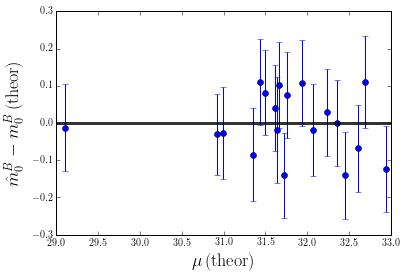

In [32]:
errorbar(model.sne.m_theory-model.params['M_0'], model.sne['m^B_0']-model.sne.m_theory, yerr = model.sne.err, fmt = 'o')
plot([29,33], [0,0], linewidth = 3, color = 'k', alpha = .8)
ylabel(r'$\hat{m}_0^B - m_0^B {\rm \, (theor)}$', fontsize = 18)
xlabel(r'$\mu {\rm \, (theor)}$', fontsize = 18)

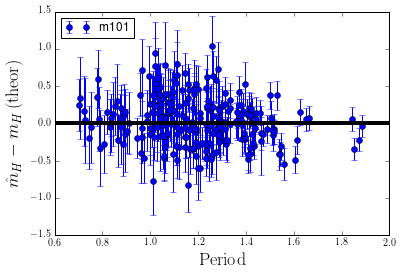

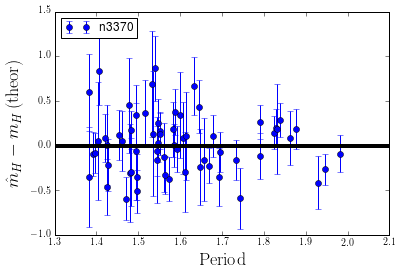

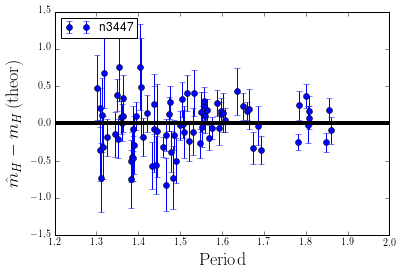

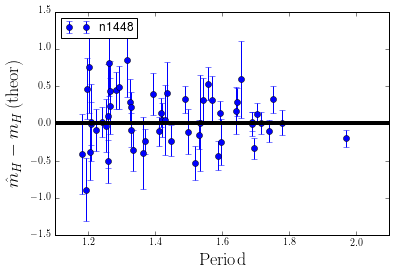

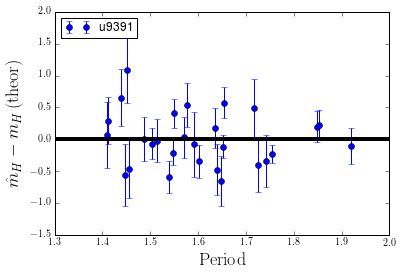

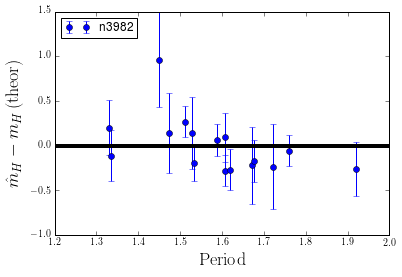

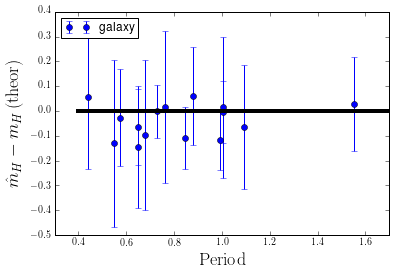

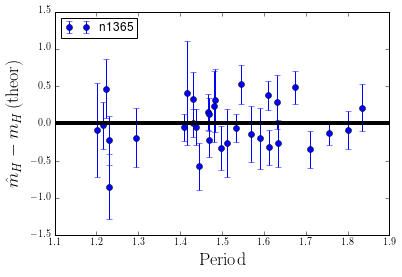

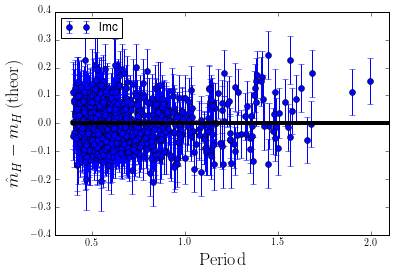

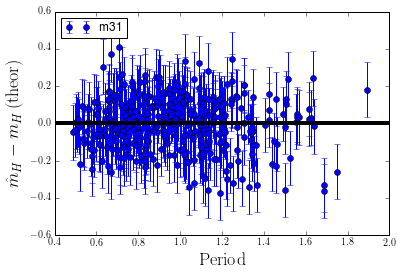

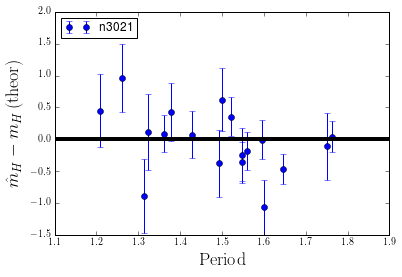

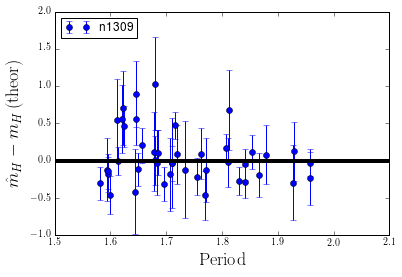

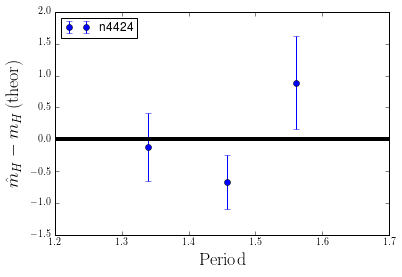

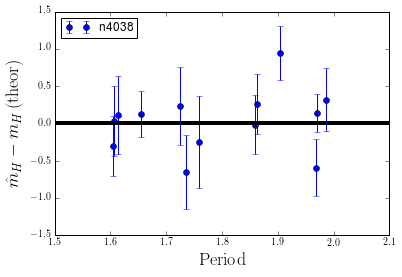

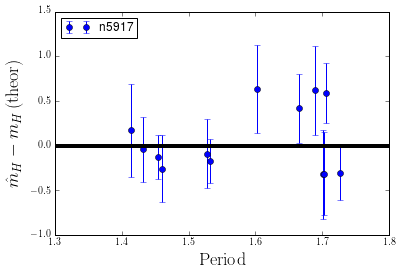

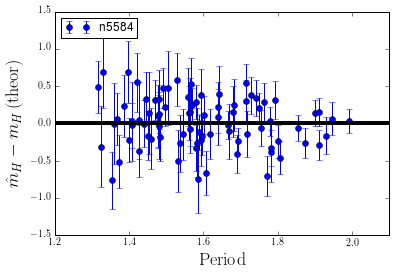

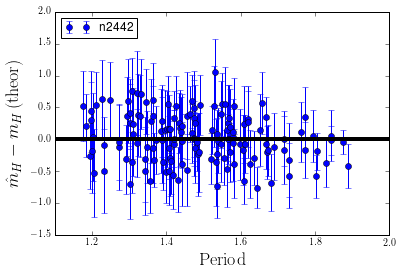

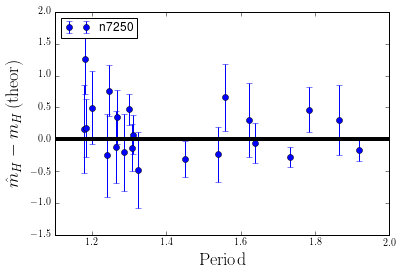

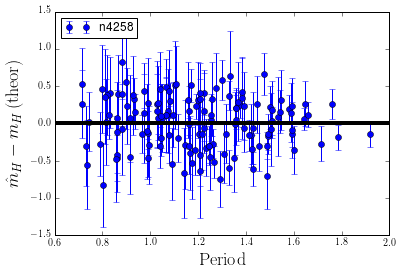

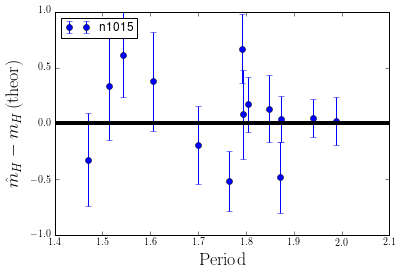

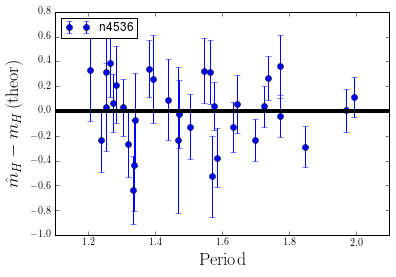

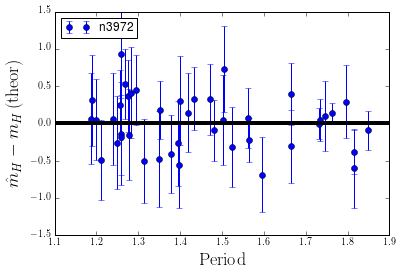

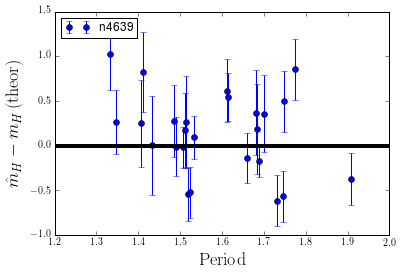

In [33]:
for field in model.fields:
    figure(figsize=(6,4))
    cephs = model.cepheids.loc[model.cepheids.Field == field, :].reset_index(drop = True)
    errorbar(
             log10(cephs.Period),
             cephs.m_theory - cephs.m_H,
             yerr = cephs.sigma_tot, 
             fmt = 'o',
             label = field
            )
    plot([0.4,2.1], [0,0], linewidth =4, color = 'k')
    xlabel(r'${\rm Period}$', fontsize = 18)
    xlim(round(min(log10(cephs.Period)),1)-0.1, round(max(log10(cephs.Period)),1)+0.1)
    ylabel(r'$\hat{m}_H - m_H {\rm \, (theor)}$', fontsize = 18)
    legend(loc = 2)
    

In [17]:
cephs = cepheids.loc[(cepheids.Field != 'galaxy') & (cepheids.Field != 'lmc'), ['RA','DEC']]
cephs.columns = ['ra', 'dec']
cephs.to_csv('/Users/follin/Downloads/RA_DEC_table.csv', index = False, header = True)

In [18]:
extinction = pd.read_csv('../extinction_map.tbl', 
                         delim_whitespace=True,
                        names = ['RA','DEC',
                                 'cutout_size','E_B_V_SandF','mean_E_B_V_SandF',
                                 'stdev_E_B_V_SandF','max_E_B_V_SandF','min_E_B_V_SandF',
                                 'AV_SandF','E_B_V_SFD','mean_E_B_V_SFD','stdev_E_B_V_SFD',
                                 'max_E_B_V_SFD','min_E_B_V_SFD','AV_SFD','errmsg']
                         )

In [19]:
extinction = extinction[['RA', 'DEC', 'E_B_V_SFD', 'mean_E_B_V_SFD', 
                        'stdev_E_B_V_SFD', 'max_E_B_V_SFD', 'min_E_B_V_SFD', 'AV_SFD']]

In [20]:
field_table = extinction.merge(cepheids[['RA','DEC','Field']], on = ['RA','DEC']).drop_duplicates(subset = 'Field')
field_table.reset_index(inplace = True)

In [21]:
fields = field_table.loc[:,'Field'].tolist()
field_table.loc[:, 'R(x)'] = model.params['R'].value
for i,field in enumerate(fields):
    field_table.loc[i,'R(x)']+= model.params['R_'+field].value

In [22]:
y = field_table['mean_E_B_V_SFD']
x = field_table['R(x)']
yerr = field_table['stdev_E_B_V_SFD']
field_table

,index,RA,DEC,E_B_V_SFD,mean_E_B_V_SFD,stdev_E_B_V_SFD,max_E_B_V_SFD,min_E_B_V_SFD,AV_SFD,Field,R(x)
0,0,210.87979,54.33376,0.0087,0.0088,0.0002,0.0091,0.0085,0.0270,m101,0.480529
1,251,39.55274,-1.33095,0.0317,0.0311,0.0010,0.0327,0.0295,0.0983,n1015,0.328238
2,265,50.51305,-15.41225,0.0400,0.0402,0.0005,0.0418,0.0396,0.1240,n1309,0.372042
3,309,53.42834,-36.16831,0.0203,0.0200,0.0009,0.0212,0.0174,0.0630,n1365,0.403210
4,341,56.17977,-44.61067,0.0143,0.0139,0.0006,0.0146,0.0117,0.0443,n1448,0.343151
5,395,114.07089,-69.55956,0.2025,0.2015,0.0027,0.2053,0.1938,0.6278,n2442,0.351057
6,536,147.75035,33.54715,0.0135,0.0136,0.0001,0.0138,0.0134,0.0418,n3021,0.435512
7,554,161.76213,17.28762,0.0307,0.0305,0.0006,0.0315,0.0292,0.0952,n3370,0.315818
8,617,163.35043,16.79001,0.0295,0.0296,0.0007,0.0307,0.0282,0.0914,n3447,0.305863
9,697,178.94031,55.31477,0.0140,0.0138,0.0003,0.0142,0.0132,0.0433,n3972,0.332716


<Container object of 3 artists>

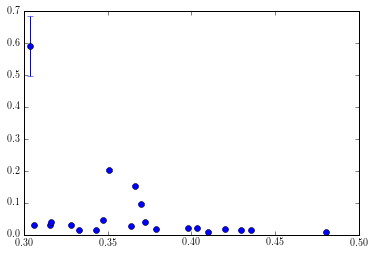

In [23]:
errorbar(x,y, yerr = yerr, fmt = 'o')

In [61]:
cepheids

,Field,RA,DEC,ID,Period,VminusI,m_H,sigma_tot,Z,parallax,p_err,LK,m_theory
0,m101,210.87979,54.33376,115287,17.950,0.96,22.47,0.302,9.134,NaN,NaN,NaN,22.705610
1,m101,210.89127,54.35620,136682,5.358,1.06,24.41,0.569,9.118,NaN,NaN,NaN,24.455342
2,m101,210.89227,54.36125,148312,11.860,1.07,22.94,0.323,9.113,NaN,NaN,NaN,23.336845
3,m101,210.89351,54.36826,164932,14.920,1.13,23.03,0.322,9.105,NaN,NaN,NaN,23.037212
4,m101,210.87982,54.33565,121146,11.860,0.96,23.14,0.448,9.136,NaN,NaN,NaN,23.290636
5,m101,210.89249,54.36142,147959,7.762,1.01,23.79,0.415,9.113,NaN,NaN,NaN,23.913260
6,m101,210.87549,54.34114,157556,25.570,1.14,22.75,0.194,9.148,NaN,NaN,NaN,22.274057
7,m101,210.88855,54.34493,112715,8.173,0.97,23.80,0.416,9.124,NaN,NaN,NaN,23.823232
8,m101,210.88664,54.34654,126118,6.969,0.83,23.84,0.427,9.129,NaN,NaN,NaN,23.992911
9,m101,210.87450,54.34108,161621,14.430,1.24,23.96,0.373,9.150,NaN,NaN,NaN,23.120802


In [62]:
10**0.16

1.4454397707459274